In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD

In [2]:
USE_TENSORFLOW_AS_BACKEND = True

In [3]:
%matplotlib inline
from scipy import misc
import seaborn

In [4]:
if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'

In [5]:
import keras
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

In [6]:
# !pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
!unzip 101_ObjectCategories.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/101_ObjectCategories/Faces_easy/image_0241.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0242.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0243.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0244.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0245.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0246.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0247.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0248.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0249.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0250.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0251.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0252.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0253.jpg  
  inflating: /content/101_

In [7]:
!ls 101_ObjectCategories

accordion	   cougar_body	    garfield	  menorah     snoopy
airplanes	   cougar_face	    gerenuk	  metronome   soccer_ball
anchor		   crab		    gramophone	  minaret     stapler
ant		   crayfish	    grand_piano   Motorbikes  starfish
BACKGROUND_Google  crocodile	    hawksbill	  nautilus    stegosaurus
barrel		   crocodile_head   headphone	  octopus     stop_sign
bass		   cup		    hedgehog	  okapi       strawberry
beaver		   dalmatian	    helicopter	  pagoda      sunflower
binocular	   dollar_bill	    ibis	  panda       tick
bonsai		   dolphin	    inline_skate  pigeon      trilobite
brain		   dragonfly	    joshua_tree   pizza       umbrella
brontosaurus	   electric_guitar  kangaroo	  platypus    watch
buddha		   elephant	    ketch	  pyramid     water_lilly
butterfly	   emu		    lamp	  revolver    wheelchair
camera		   euphonium	    laptop	  rhino       wild_cat
cannon		   ewer		    Leopards	  rooster     windsor_chair
car_side	   Faces	    llama	  saxophone   wrench
ceiling_fan	   Faces_e

In [8]:
# functions to load the data
# def load_batch_images(path, n_examples_train, n_examples_validation=2, max_imgs_by_class=30, nb_categories=4, resize_to_size=(224,224)):

def load_batch_images(path, n_examples_train, n_examples_validation=2, max_imgs_by_class=30, nb_categories=4, resize_to_size=(224,224)):

    images_train = []
    labels_train = []
    images_validation = []
    labels_validation = []
    
    # Get categories from path
    categories_list = os.listdir(path)
    categories_list = [category for category in categories_list if category != '.DS_Store']
    if isinstance(nb_categories, int) and len(categories_list) >= nb_categories:
        categories_list = categories_list[0:nb_categories]

    # For each category...
    for idx, category in enumerate(categories_list):
        # ... get images in category ...
        images_list = os.listdir(os.path.join(path, category))        
        if len(images_list) > max_imgs_by_class:
            images_list = images_list[:max_imgs_by_class]
        
        indx = 0
        for images in images_list[:n_examples_train + n_examples_validation]:                
            # ... load them ...
            img = load_img(os.path.join(path, category, images))  # as PIL images
            img = img_to_array(img)                               # as numpy array
            img = misc.imresize(img, resize_to_size)              # resize
            # img = misc.imrotate(img, 180)
            if indx < n_examples_train:
                images_train.append(img)
                labels_train.append(idx)
            else:
                images_validation.append(img)
                labels_validation.append(idx)
            indx += 1
    
    # Convert to one-hot
    labels_train = np_utils.to_categorical(labels_train)
    labels_validation = np_utils.to_categorical(labels_validation)

    return images_train, labels_train, images_validation, labels_validation


In [9]:
def shuffle_dataset(a, b):
    """Shuffle the entire dataset"""
    assert np.shape(a)[0] == np.shape(b)[0]
    p = np.random.permutation(np.shape(a)[0])
    return (a[p], b[p])

In [10]:
def get_data(samples_by_category=8, dataset_path="./101_ObjectCategories/", nb_categories=4):
    images_train, labels_train, images_validation, labels_validation = load_batch_images(path=dataset_path, n_examples_train=samples_by_category, n_examples_validation=20, max_imgs_by_class=30, nb_categories=nb_categories)

    images_train = np.float64(images_train)
    images_validation = np.float64(images_validation)

    images_train = preprocess_input(images_train)  # substract the mean RGB channels of the imagenet dataset. This is because the Inception model we are using has been trained on a different dataset (imagenet dataset)
    images_validation = preprocess_input(images_validation)

    if not USE_TENSORFLOW_AS_BACKEND:
        images_validation = images_validation.swapaxes(1, 3).swapaxes(2, 3)
        images_train = images_train.swapaxes(1, 3).swapaxes(2, 3)

    train = shuffle_dataset(np.asarray(images_train), labels_train)
    validation = shuffle_dataset(np.asarray(images_validation), labels_validation)

    images_train, labels_train = train
    images_validation, labels_validation = validation

    return images_train, labels_train, train, images_validation, labels_validation, validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


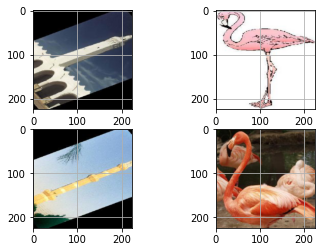

In [11]:
def demo_plot():
    demo_path = "./101_ObjectCategories/"

    demo_data, _, _, _ = load_batch_images(path=demo_path, n_examples_train=8, n_examples_validation=20)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(demo_data[0])
    axarr[1,0].imshow(demo_data[1])
    axarr[0,1].imshow(demo_data[27])
    axarr[1,1].imshow(demo_data[31])
    axarr[0,0].grid('off')
    axarr[0,1].grid('off')
    axarr[1,0].grid('off')
    axarr[1,1].grid('off')
    plt.show()

demo_plot()

In [12]:
nb_categories = 50  #4         # out of 101 classes
samples_by_category = 29  # out of about 50 images for each category

# Load the data!
train_img, train_labels, train, val_img, val_labels, val = get_data(samples_by_category=samples_by_category, dataset_path='./101_ObjectCategories/', nb_categories=nb_categories)

# # Normalize pixel values to be between 0 and 1
# train_img, val_img = train_img / 255.0, val_img / 255.0

# Print the tensors shapes
print('Shapes (train) :', train_img[0].shape, train_labels[0].shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Shapes (train) : (224, 224, 3) (50,)


**Data Augmentation**

In [13]:
import albumentations as A
import cv2

In [14]:
transform = A.Compose([
  A.RandomCrop(width=224, height=224),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(p=0.2)
])

In [15]:
aug_images = []
aug_labels = []

for _ in range(2):
  for im, Label in zip(train_img, train_labels):
      res = transform(image=im, label=Label)
      aug_images += [res['image']]
      aug_labels += [res['label']]

In [16]:
base_model = MobileNetV3Small(input_shape=(224,224,3), classes=50,
                             weights="imagenet", pooling=None, include_top=False)

4349952/4334752 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    # layer.trainable = True

last_output = base_model.layers[-1].output
inputs = tf.keras.Input(shape=(224, 224, 3))

# x = data_augmentation(inputs)
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(50, activation='softmax')(x)


model = Model(base_model.input, x)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(np.array(aug_images), np.array(aug_labels),batch_size=2, validation_data=(val_img, val_labels), epochs=25)

Epoch 1/25
1450/1450 [==============================] - 37s 15ms/step - loss: 4.0373 - acc: 0.0610 - val_loss: 3.7825 - val_acc: 0.1200
Epoch 2/25
1450/1450 [==============================] - 20s 14ms/step - loss: 2.8437 - acc: 0.2617 - val_loss: 3.8043 - val_acc: 0.1400
Epoch 3/25
1450/1450 [==============================] - 21s 14ms/step - loss: 2.0145 - acc: 0.4366 - val_loss: 3.8257 - val_acc: 0.2000
Epoch 4/25
1450/1450 [==============================] - 20s 14ms/step - loss: 1.4112 - acc: 0.6052 - val_loss: 3.2924 - val_acc: 0.3000
Epoch 5/25
1450/1450 [==============================] - 20s 14ms/step - loss: 1.0202 - acc: 0.7010 - val_loss: 2.0522 - val_acc: 0.5000
Epoch 6/25
1450/1450 [==============================] - 20s 14ms/step - loss: 0.7516 - acc: 0.7797 - val_loss: 2.2264 - val_acc: 0.5400
Epoch 7/25
1450/1450 [==============================] - 20s 14ms/step - loss: 0.6309 - acc: 0.8128 - val_loss: 3.1703 - val_acc: 0.4200
Epoch 8/25
1450/1450 [==========================

2/2 - 2s - loss: 2.8914 - acc: 0.6000 - 2s/epoch - 843ms/step


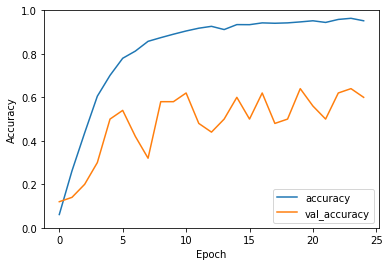

In [20]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_img,  val_labels, verbose=2)

In [21]:
print(test_acc)

0.6000000238418579
